In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encdoing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style = 'white', context='notebook', palette='deep')

# Data Preparation

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

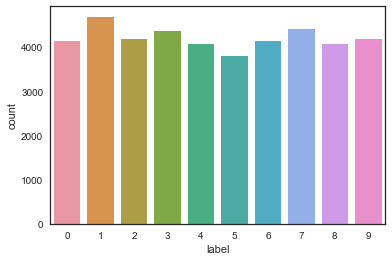

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train['label']
X_train = train.drop(labels=['label'],axis=1)

del train

g = sns.countplot(Y_train)
Y_train.value_counts()

In [12]:
# 处理缺失值
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [13]:
test.isnull().any().describe()
# 运行结果显示没有缺失值

count       784
unique        1
top       False
freq        784
dtype: object

In [14]:
#正则化
X_train = X_train/255.0
test = test/255.0

In [16]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [17]:
# Label encoding
# eg: y = 2 -> [0,0,1,0,0,0,0,0,0]
Y_train = to_categorical(Y_train, num_classes = 10)

In [18]:
# 设置训练集与开发集
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

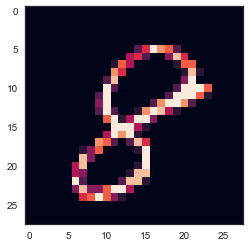

In [19]:
g = plt.imshow(X_train[0][:,:,0])

# 3.CNN

In [21]:
## 模型结构： RElu卷积层*2 -> 最大池化 -> Dropout层*2（防止过拟合）-> Flatten -> 全连接层 -> Dropout
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu', input_shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding='Same',
                activation='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding='Same',
               activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## 3.2 Optimizer and annealer

In [25]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon=1e-08, decay=0.0)

In [26]:
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [32]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accyract
batch_size = 86

## 3.3 Data augmentation

In [35]:
# 常用技术有grayscales, horizontal flips, vertical flips, random crops, color jitters, translation, 旋转等等
datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range = 10, # Randomly zoom image
        width_shift_range=0.1, # randomly shift images for horizontally(fraction of total width)
        height_shift_range = 0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip = False, # randomly flip images
        vertical_flip = False # randomly flip images
    )
    
datagen.fit(X_train)

In [36]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs = epochs, validation_data=(X_val,Y_val),
                             verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                             callbacks = [learning_rate_reduction])


Epoch 1/30
 - 255s - loss: 0.3876 - acc: 0.8769 - val_loss: 0.0689 - val_acc: 0.9793
Epoch 2/30
 - 253s - loss: 0.1209 - acc: 0.9643 - val_loss: 0.0601 - val_acc: 0.9810
Epoch 3/30
 - 243s - loss: 0.0911 - acc: 0.9727 - val_loss: 0.0597 - val_acc: 0.9831
Epoch 4/30
 - 231s - loss: 0.0791 - acc: 0.9768 - val_loss: 0.0368 - val_acc: 0.9888
Epoch 5/30
 - 216s - loss: 0.0676 - acc: 0.9801 - val_loss: 0.0263 - val_acc: 0.9921
Epoch 6/30
 - 216s - loss: 0.0649 - acc: 0.9809 - val_loss: 0.0317 - val_acc: 0.9933
Epoch 7/30
 - 242s - loss: 0.0621 - acc: 0.9822 - val_loss: 0.0237 - val_acc: 0.9926
Epoch 8/30
 - 235s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.0226 - val_acc: 0.9924
Epoch 9/30
 - 241s - loss: 0.0582 - acc: 0.9834 - val_loss: 0.0255 - val_acc: 0.9924
Epoch 10/30
 - 236s - loss: 0.0560 - acc: 0.9848 - val_loss: 0.0333 - val_acc: 0.9902

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 242s - loss: 0.0448 - acc: 0.9870 - val_loss: 0.0217 

# 4.Evaluate the model

## 4.1 Training and Validation curves

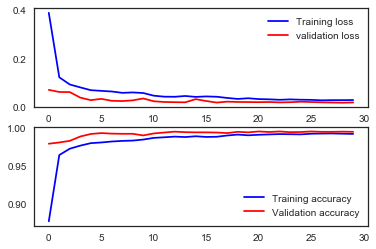

In [38]:
# plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes = ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'],color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc = 'best', shadow=True)

## 4.2 Confusion matrix

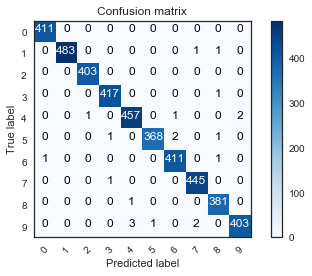

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
        '''
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting 'normalize=True
        '''
        plt.imshow(cm, interpolation='nearest', cmap = cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation = 45)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
            plt.text(j,i, cm[i,j],
                    horizontalalignment='center',
                    color = 'white' if cm[i,j] > thresh else 'black')
            
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            
# predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# COmpute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10))

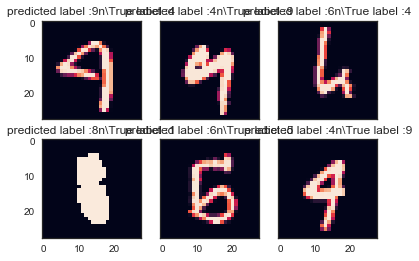

In [49]:
# Display some error results

# Erros are differnece between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    '''This is function show 6 images with the predicted and real labels'''
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row, col].set_title('predicted label :{}n\True label :{}'.format(pred_errors[error],
                                                                               obs_errors[error]))
            n += 1
            
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Differnece between the probability of the predicted label and the truw label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)



In [50]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [54]:
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results],axis=1)
submission.to_csv('cnn_mnist_datafen.csv',index=False)